In [1]:
pwd

'/home/pranshumaan'

In [2]:
cd /media/pranshumaan/TOSHIBA\ EXT

/media/pranshumaan/TOSHIBA EXT


In [3]:
cd Dev/Deep_Learning_Pytorch_Udemy_Tutorial/

/media/pranshumaan/TOSHIBA EXT/Dev/Deep_Learning_Pytorch_Udemy_Tutorial


In [4]:
cd Paper_Replication/

/media/pranshumaan/TOSHIBA EXT/Dev/Deep_Learning_Pytorch_Udemy_Tutorial/Paper_Replication


In [5]:
ls

2010.11929.pdf  data/  going_modular/  helper_functions.py


## Replicating Vision Transformer (ViT) architecture paper in Pytorch

#### Importing prewritten code and helper functions

In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

#### Loading image data

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
device

'cuda'

In [9]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [10]:
!tree

.
├── 2010.11929.pdf
├── data
│   └── pizza_steak_sushi
│       ├── test
│       │   ├── pizza
│       │   │   ├── 1152100.jpg
│       │   │   ├── 1503858.jpg
│       │   │   ├── 1687143.jpg
│       │   │   ├── 1925494.jpg
│       │   │   ├── 194643.jpg
│       │   │   ├── 195160.jpg
│       │   │   ├── 2003290.jpg
│       │   │   ├── 2019408.jpg
│       │   │   ├── 2111981.jpg
│       │   │   ├── 2124579.jpg
│       │   │   ├── 2218680.jpg
│       │   │   ├── 2236338.jpg
│       │   │   ├── 2508636.jpg
│       │   │   ├── 2871261.jpg
│       │   │   ├── 3092704.jpg
│       │   │   ├── 309892.jpg
│       │   │   ├── 344397.jpg
│       │   │   ├── 3475871.jpg
│       │   │   ├── 398345.jpg
│       │   │   ├── 416067.jpg
│       │   │   ├── 540882.jpg
│       │   │   ├── 648055.jpg
│       │   │   ├── 714866.jpg
│       │   │   ├── 930553.jpg
│       │   │   └── 971934.jpg
│       │   ├── steak
│       │   │   ├── 100274.jpg
│       │   │   ├── 1016217.jpg
│       │   │   ├── 1285886.jpg

In [11]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [12]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()])

print(f"Manually created transform: {manual_transforms}")

Manually created transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [13]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE
                                                                              )
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

#### Visualizing a single image

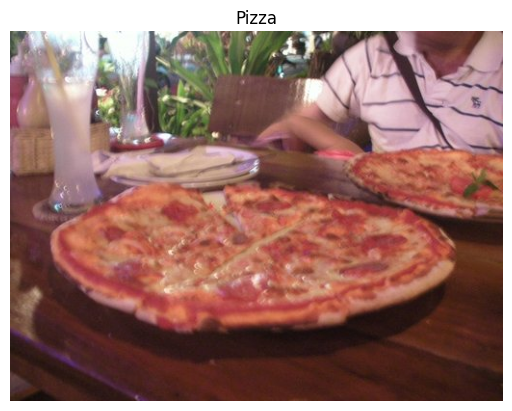

In [14]:
import random
from PIL import Image

random_image_file = random.choice(train_dataloader.dataset.samples)
random_image = random_image_file[0]
random_image_label = class_names[random_image_file[1]]

with Image.open(random_image) as im:
    plt.imshow(im)
    plt.axis('off')
    plt.title(random_image_label.title())

#### Split image into patches and create the class, position and patch embedding

In [15]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int(((height*width)/patch_size**2))
number_of_patches

196

In [16]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


In [17]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

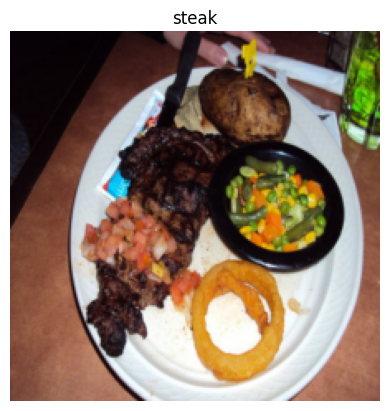

In [18]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [19]:
image.shape

torch.Size([3, 224, 224])

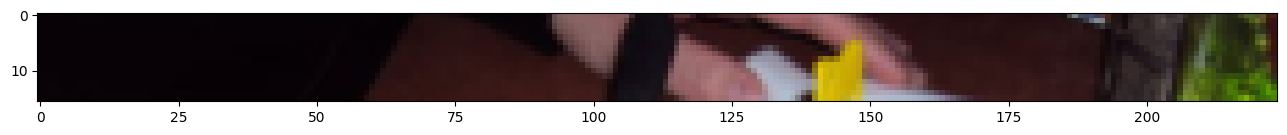

In [20]:
image_permuted = image.permute(1,2,0) # color channels first, HxWxC

patch_size = 16
plt.figure(figsize = (patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

>It's all about the embedding

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


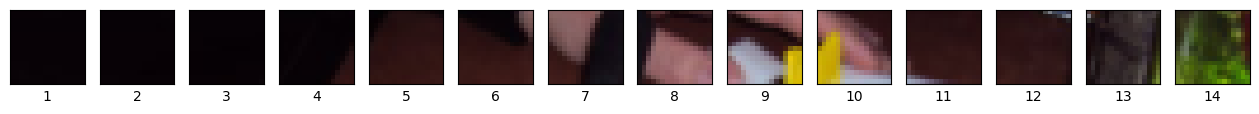

In [21]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0 #image size must be divisible by patch size

print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")
fig, axs = plt.subplots(nrows = 1,
                        ncols = int(img_size / patch_size),
                        sharex = True,
                        sharey= True,
                        figsize=(patch_size,patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [22]:
enumerate(range(0, img_size, patch_size)).__next__()

(0, 0)

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


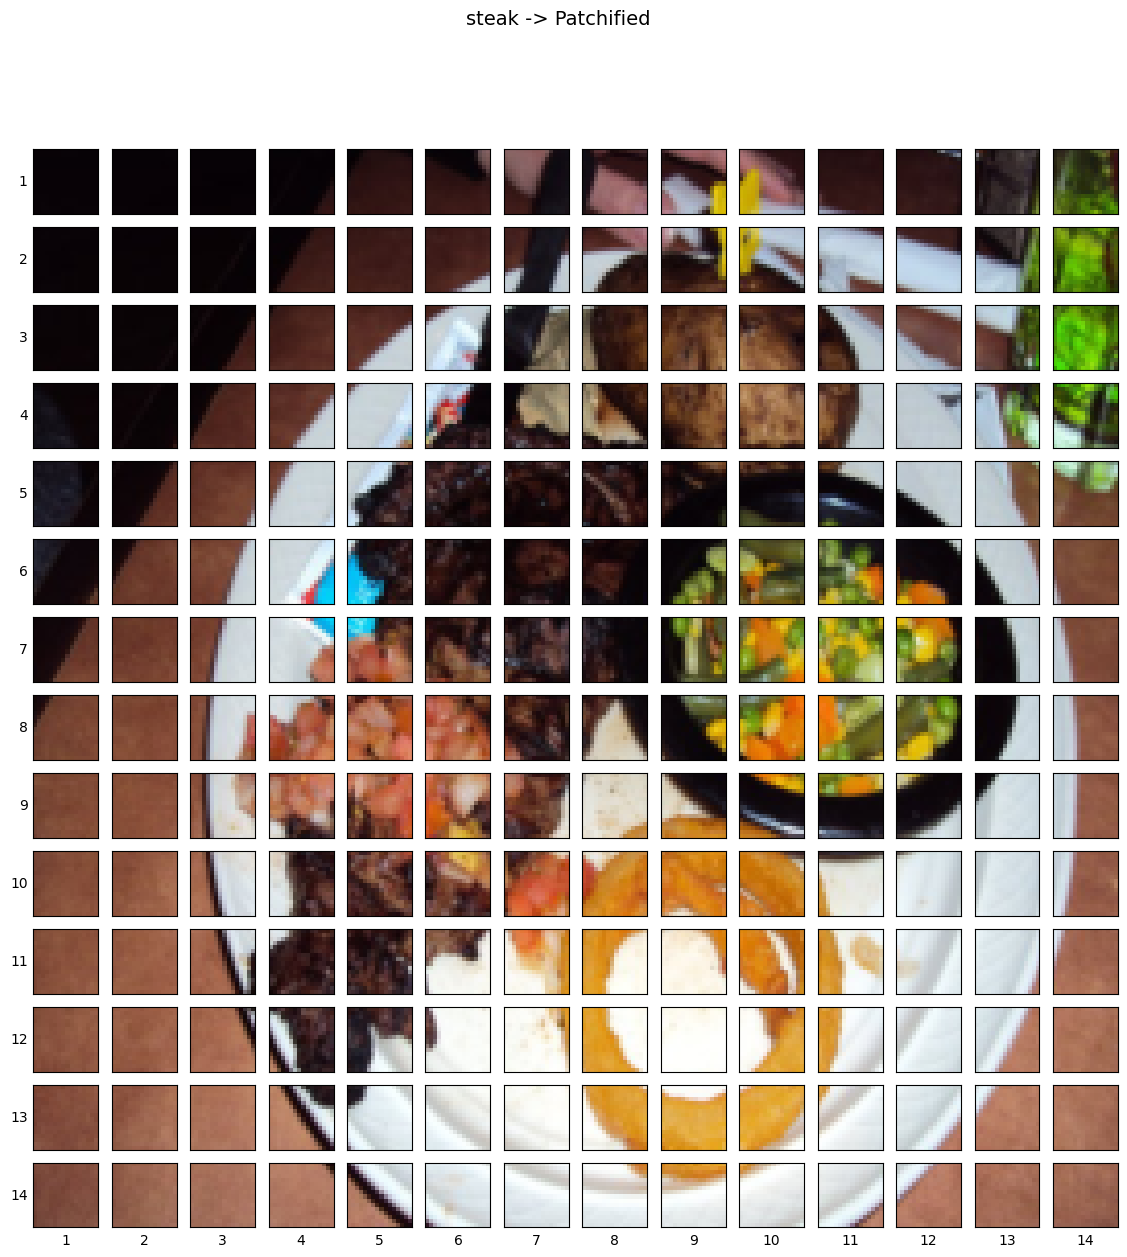

In [23]:
img_size = 224
patch_size = 16
num_patches = int(img_size / patch_size)
assert img_size % patch_size == 0 #image size must be divisible by patch size

print(f"Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal patches: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=int(img_size/patch_size),
                        ncols=int(img_size/patch_size),
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        axs[i, j].set_ylabel(i+1,
                             rotation='horizontal',
                             horizontalalignment='right',
                             verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
        
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

#### Turning patches into patch embeddings
We can convolve over the image to directly create the patch embeddings.
The convolution kernel of patch_size moves over the image creating the embedding for that patch. This gives the feature map, which flattedned to get the input for the encoder.

In [24]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, #3x16^2, 3 channels of 16x16 size patches
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

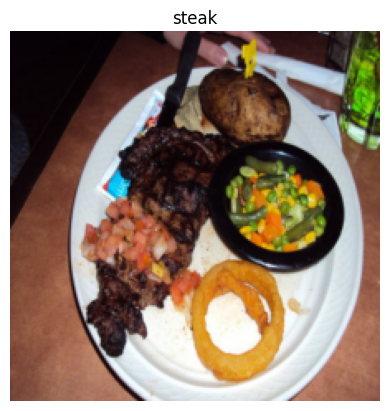

In [25]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [26]:
image_out_of_conv = conv2d(image.unsqueeze(0)) #batch dimension included
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

```
torch.Size([1, 768, 14, 14])
```
[batch_size, embedding_dim, feature_map_height, feature_map_width]

In [27]:
image_out_of_conv.flatten(2,3).shape

torch.Size([1, 768, 196])

Showing random convolution feature map from random indexes: [617, 496, 454, 612, 210]


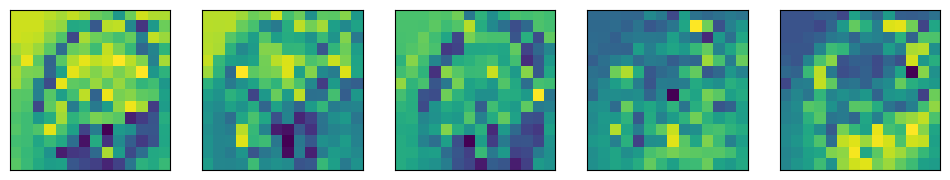

In [28]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolution feature map from random indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [29]:
image_out_of_conv.requires_grad

True

In [30]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.shape, single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

In [31]:
#Flattening the patch embedding
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
image_out_of_conv_flattened.shape

image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_permuted.shape

torch.Size([1, 196, 768])

In [32]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]
single_flattened_feature_map

tensor([[ 2.8791e-03,  3.2187e-03,  6.4549e-03, -2.4407e-03, -8.9665e-02,
         -1.7001e-01, -1.3199e-01, -3.3793e-01, -3.7208e-01, -2.6875e-01,
         -6.4363e-02, -1.1563e-01, -1.7156e-01, -1.6934e-01, -8.9221e-06,
          1.4818e-03,  2.7923e-03, -1.3735e-01, -1.2784e-01, -7.7122e-02,
         -1.0387e-01, -3.6146e-01, -2.4016e-01, -3.5552e-01, -7.8593e-01,
         -6.2464e-01, -3.6763e-01, -4.1624e-01, -3.5025e-03, -4.9087e-03,
         -4.2539e-02, -1.8626e-01, -2.9433e-01, -9.0056e-01, -3.0615e-01,
         -9.0323e-02, -2.9872e-01, -1.7621e-01, -3.2963e-01, -3.8472e-01,
         -3.2417e-01, -4.3522e-01, -2.6021e-02, -1.3456e-02, -2.2028e-01,
         -2.9113e-01, -8.5795e-01, -2.0030e-01, -5.7279e-01, -2.4323e-01,
         -2.7895e-01, -4.3618e-01, -4.3877e-01, -7.4487e-01, -5.5270e-01,
         -2.6692e-01, -5.8735e-02, -1.0678e-01, -2.5129e-01, -7.9345e-01,
         -1.4947e-01, -1.1337e-01, -6.6903e-02, -1.2435e-01, -4.2789e-02,
         -1.3159e-02, -2.9254e-01, -7.

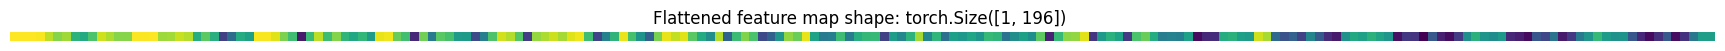

In [33]:
plt.figure(figsize=(22,22))
plt.axis(False)
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape} ")
plt.imshow(single_flattened_feature_map.detach().numpy());

In [34]:
#Creating the patch embedding layer by combining the 2d Conv and flatten layers

patch_embedding_layer = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=768, #3x16^2, 3 channels of 16x16 size patches
                                                kernel_size=patch_size,
                                                stride=patch_size,
                                                padding=0),
                                      nn.Flatten(start_dim=2, end_dim=3))

#### Creating the Patch embedding layer

In [35]:
# class PatchEmbedding(nn.Module):
    
#     def __init__(self,
#                  in_channels:int=3,
#                  patch_size: int=16,
#                  emebedding_dim: int=768):
        
#         super().__init__()
        
#         self. patch_embedding_layer = nn.Sequential(nn.Conv2d(in_channels=3,
#                                                               out_channels=768, #3x16^2, 3 channels of 16x16 size patches
#                                                               kernel_size=patch_size,
#                                                               stride=patch_size,
#                                                               padding=0),
#                                                     nn.Flatten(start_dim=2, end_dim=3))
    
#     def forward(self, x):
#         x = self.patch_embedding_layer(x)
#         return x

In [36]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,
                 in_channels:int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim 
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size ==0, f"Image resolution must be divisible by patch size."
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

In [37]:
set_seeds()

In [38]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Patch embedded image: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Patch embedded image: torch.Size([1, 196, 768])


In [39]:
rand_image_tensor = torch.randn(1,3,200,200)
patchify(rand_image_tensor)

AssertionError: Image resolution must be divisible by patch size.

#### Creating the class token embedding
Prepending a learnable class token to the start of the patch embedding

In [40]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [41]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [42]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) #Using tensor of ones to be visible easily
class_token.shape

torch.Size([1, 1, 768])

In [43]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [44]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
         [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
         ...,
         [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
         [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
         [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
       grad_fn=<CatBackward0>)

#### Creating the position embedding
1D learnable position embeddings to be added to the sequence of patch embeddings

In [45]:
number_of_patches = int((height*width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

#Learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                 requires_grad=True)
position_embedding.shape, position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True))

In [46]:
# Adding the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [47]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9571, 0.9887, 0.9677,  ..., 1.0222, 0.9862, 1.0130],
         [0.9583, 0.9890, 0.9684,  ..., 1.0199, 0.9869, 1.0109],
         ...,
         [0.4095, 0.9769, 0.9962,  ..., 1.4907, 0.5243, 1.2497],
         [0.4609, 1.0619, 0.9028,  ..., 1.3296, 0.7381, 1.2086],
         [0.4994, 1.0595, 0.9187,  ..., 1.3091, 0.7423, 1.2046]]],
       grad_fn=<AddBackward0>)

In [48]:
torch.count_nonzero(patch_and_position_embedding) #just checking

tensor(151296)

In [49]:
1*197*768 #just checking

151296

#### Putting it all together: from image to embedding

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
set_seeds()

In [51]:
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create and add position embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#### The MSA Block (Multi Headed Self Attention)
[Good explanation of intuition behind multi head attention and transformers](
https://www.youtube.com/watch?v=g2BRIuln4uc)